#### **Download and check**

In [96]:
import math
import cv2

import pickle
import imageio
import time
import os
import shutil
import json
import sys
from shutil import copyfile
from PIL import Image
import numpy as np
from tqdm import tqdm

from subprocess import Popen, PIPE
from sys import stdout, stderr

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from torchvision.io import read_image
from torchvision import transforms
from torchsummary import summary
from torchvision.transforms import ToTensor, ToPILImage

import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import clear_output

In [2]:
# a = ToTensor()(Image.open('./0001_org.png')).float() / 255.0
# a.shape

# vqmt -orig 0001_org.png IYUV 1080x1920 -in 0001.png IYUV 1080x1920 -metr vmaf -set "model_preset=vmaf_v063" -json -threads 3

# vqmt -in "{original_yuv}" IYUV {width} {height} -in "decoded_yuv" IYUV
# {width} {height} metrics_list -subsampling -json -json_file "{json_filename}" -threads
# 3

# vqmt -in  IYUV {width}x{height} -stdin raw IYUV {width}x{height}

In [3]:
# vqmt -orig 0001_org.png IYUV 1080x1920 -in 0001.png IYUV 1080x1920 -metr vmaf -set "model_preset=vmaf_v063" -json -json_file json_files.json -threads 3

In [4]:
rename_vmaf = lambda file: '_'.join(file.split('_')[2:])

def rename_folder_files(path, prefix, rename_fn, extension):
    for file in os.listdir(path):
        if not file.startswith(prefix):
            continue
        new_name = rename_fn(file)
        os.rename(f'{path}/{file}', f'{path}/{new_name}{extension}')

def merge_folders_with_prefix(store_path, folders, out_folder):
    for folder in folders:
        if not os.path.isdir(f'{store_path}/{folder}'):
            continue
        for file in os.listdir(f'{store_path}/{folder}'):
            copyfile(f'{store_path}/{folder}/{file}', f'{out_folder}/{folder}_{file}')

In [5]:
# path = './data/existing1/2020_blue_hair'
# rename_folder_files(path, 'enc_res', rename_vmaf, '')

# rename_folder_files(path, 'vmaf', rename_vmaf, '')

# merge_folders_with_prefix('./enc_images', os.listdir('./enc_images'), './encc_images')

In [176]:
path = './data/encoder_packs'
all_codecs = set(os.listdir(path))

In [177]:
exclude_codes = {
    'bytedance_hevc_mv_fast_2k_blue_hair_28',
    'bytedance_hevc_mv_fast_2k_blue_hair_32',
    'bytedance_hevc_mv_fast_2k_blue_hair_37',
    'bytedance_hevc_mv_offline_2k_blue_hair_28',
    'bytedance_hevc_mv_offline_2k_blue_hair_32',
    'bytedance_hevc_mv_offline_2k_blue_hair_37',
}

In [178]:
test_codecs = {
    'alibaba_mv_offline_2k_blue_hair_32',
    'x265_ref_mv_fast_2k_blue_hair_28',
    'baidu_mv_fast_2k_blue_hair_30',
    'qav1enc_mv_offline_2k_blue_hair_182',
}

In [229]:
val_codecs = {
    'x264_mv_fast_2k_blue_hair_31',
    'xcczm265_mv_offline_2k_blue_hair_29',
    'alibaba_mv_offline_2k_blue_hair_32',
    'kingsoft_v2_mv_offline_2k_blue_hair_39',
}

In [222]:
def refresh_folder(folder):
    shutil.rmtree(folder, ignore_errors=True)
    os.mkdir(folder)

In [231]:
# refresh_folder('./data/enc_val')
# merge_folders_with_prefix(path, val_codecs, './data/enc_val')

In [183]:
# refresh_folder('./data/enc_train')
# merge_folders_with_prefix(path, list(all_codecs - test_codecs - exclude_codes), './data/enc_train')

In [ ]:
# refresh_folder('./data/enc_train')

In [10]:
# refresh_folder('./data/enc_train')

# refresh_folder('./data/enc_test')

# merge_folders_with_prefix(path, list(all_codecs - test_codecs), './data/enc_train')

# merge_folders_with_prefix(path, test_codecs, './data/enc_test')

# path = './data/origin_packs'

# merge_folders_with_prefix(path, os.listdir(path), './data/original_images')

In [184]:
def find_suff_in_set(path, st):
    tokens = path.split('_')
    tokens = tokens[:-2] + tokens[-1:]
    for suff_len in range(2, len(tokens)):
        suffix = '_'.join(tokens[-suff_len:])
        if suffix in st:
            return suffix
    raise f'path {path} do not have prototype in set'

In [203]:
class FramesDataset(Dataset):
    def __init__(self, enc_folder, org_folder, json_dir, transform=None):
        self.enc_folder = enc_folder
        self.enc_name2path = {
            enc_img: os.path.join(enc_folder, enc_img) for enc_img in os.listdir(enc_folder)
        }
        
        self.org_folder = org_folder
        self.org_file_names = set([img for img in os.listdir(org_folder)])
        
        self.enc_to_org_paths = {
            enc_path: os.path.join(org_folder, find_suff_in_set(enc_name, self.org_file_names))
            for enc_name, enc_path in self.enc_name2path.items()
        }
        
        self.json_dir = json_dir
        self.jsons = {}
        for jsn in os.listdir(json_dir):
            jsn_name = jsn.split('.')[0]
            with open(os.path.join(json_dir, jsn), 'r') as f:
                for img_idx, vmaf in json.load(f).items():
                    self.jsons[f'{jsn_name}_{int(img_idx):04d}.png'] = vmaf
        
        self.item_names = list(self.enc_name2path.keys())
        
        self.transform = transform
        self.to_tensor = ToTensor()

    def __len__(self):
        return len(self.item_names)

    def __getitem__(self, idx):
        try:
            enc_name = self.item_names[idx]
            enc_path = self.enc_name2path[enc_name]

            curr_frame = self.to_tensor(Image.open(enc_path)).float()

            ref_frame = self.to_tensor(
                Image.open(self.enc_to_org_paths[enc_path])
            ).float()

            if self.transform:
                curr_frame = self.transform(curr_frame)
                ref_frame = self.transform(ref_frame)

            vmaf = self.jsons[enc_name]
            
        except KeyboardInterrupt:
            raise '1'
        except BaseException:
            return self.__getitem__((idx + 1)  % len(self))
            
        return curr_frame, ref_frame, torch.tensor(vmaf), enc_path

In [204]:
train_dataset = FramesDataset('./data/enc_train', './data/original_images', './data/vmafs')
val_dataset = FramesDataset('./data/enc_test', './data/original_images', './data/vmafs')

In [205]:
curr_frame, ref_frame, vmaf, paths = next(iter(train_dataset))

#### **Hyperparameters**

In [206]:
#@title Create dataset, reshape and normalize
PATH = "dataset/dataset" #@param {type:"string"}
quality = "SD (480, 640)" #@param ["FullHD (1080, 1920)", "HD (720, 1280)", "SD (480, 640)"]

d = {"FullHD (1080, 1920)": (1080, 1920),
     "HD (720, 1280)": (720, 1280),
     "SD (480, 640)":(480, 640)}

transform = torchvision.transforms.Compose([
    transforms.Resize(d[quality]),
#     transforms.Normalize((0.3345,), (0.3491,))
])

trainset = FramesDataset('./data/enc_train', './data/original_images', './data/vmafs', transform=transform)
testset = FramesDataset('./data/enc_test', './data/original_images', './data/vmafs', transform=transform)
clear_output()

In [207]:
BATCH_SIZE = 16 #@param {type:"slider", min:4, max:64, step:2}
EPOCHS = 30 #@param {type:"slider", min:5, max:100, step:5}
device = 'cuda' #@param ["cuda", "cpu"]


assert device == str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

In [208]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)

In [209]:
im_train, ref_train, scores_train, paths = next(iter(trainloader))

In [19]:
# dcn(ref_train[0][0])

In [20]:
# with open('./proxy_model', 'rb') as f:
#     print(model.load_state_dict(torch.load(f)))

In [114]:
im_train, ref_train, scores_train, paths = next(iter(trainloader))
print(f"Train dataset: {len(trainset)} items")
print(f"Batches num: {len(trainloader)}")
print("Images shape:", im_train.size()) # images, ref_images, scores
print("Refimg shape:", ref_train.size())
print("Scores shape:", len(scores_train))
if len(trainset) % BATCH_SIZE != 0:
    print("WARNING: Last train batchsize is different to BATCH_SIZE. Last batch len:", len(testset) % BATCH_SIZE)


im_test, ref_test, scores_test, paths = next(iter(testloader))
print(f"\nTrain dataset: {len(testset)} items")
print(f"Batches num: {len(testloader)}")
print("Images shape:", im_test.size()) # images, ref_images, scores
print("Refimg shape:", ref_test.size())
print("Scores shape:", len(scores_test))
if len(testset) % BATCH_SIZE != 0:
    print("WARNING: Last test batchsize is different to BATCH_SIZE. Last batch len:", len(trainset) % BATCH_SIZE)

Train dataset: 17394 items
Batches num: 1087
Images shape: torch.Size([16, 1, 480, 640])
Refimg shape: torch.Size([16, 1, 480, 640])
Scores shape: 16

Train dataset: 1061 items
Batches num: 66
Images shape: torch.Size([16, 1, 480, 640])
Refimg shape: torch.Size([16, 1, 480, 640])
Scores shape: 16


#### **Train loop**

In [115]:
class Plotter():
    def __init__(self):
        self.train_loss_hist = []
        self.test_loss_hist = []

    def append_train_loss(self, loss):
        self.train_loss_hist.append(loss)

    def append_test_loss(self, loss):
        self.test_loss_hist.append(loss)

    def print_last(self):
        assert len(self.train_loss_hist) == len(self.test_loss_hist)
        print(f"[Epoch={len(self.train_loss_hist)}]\ttrain loss={self.train_loss_hist[-1]:.4}\ttest loss={self.test_loss_hist[-1]:.4}")

    def start_time(self):
        self.start_t = time.time()

    def print_time(self):
        end = time.time()
        print(f"Epoch time = {(end - self.start_t):.4}s \n")
    
    def show(self):
        plt.plot(range(1, len(self.train_loss_hist)+1), self.train_loss_hist, label='Train')
        plt.plot(range(1, len(self.test_loss_hist)+1), self.test_loss_hist, label='Test')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Loss by epochs")
        plt.legend()
        plt.show()

In [116]:
def calc_loss(model, loader, loss_function):
    ep_loss = 0
    for images, ref_images, scores in loader:
        images = images.to(device)
        ref_images = ref_images.to(device)
        scores = scores.to(device)
        scores = scores / 100 # re-normalise

        predicted_scores = model(images, ref_images) # call forward inside 
        loss = loss_function(predicted_scores.float()[:,0], scores.float()) # calculate loss
        ep_loss += loss.item()
    return ep_loss

In [117]:
def train_with_valid(model, trainloader, testloader, loss_function, optimizer, epochs, device, plot):
    for epoch in range(epochs):
        plot.start_time()
        plot.append_train_loss(calc_loss(model, trainloader, loss_function)/len(trainset))
        plot.append_test_loss(calc_loss(model, testloader, loss_function)/len(testset))
        
        for images, ref_images, scores in trainloader:
            images = images.to(device)
            ref_images = ref_images.to(device)
            scores = scores/100 # re-normalise
            scores = scores.to(device)
            
            out = model(images, ref_images)

            optimizer.zero_grad()
            loss = loss_function(out.float().squeeze(), scores.float())
            loss.backward()
            optimizer.step()
        
        plot.print_last()
        plot.print_time()

**Model**

In [118]:
class Block(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.sequence = nn.Sequential(
            nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_features),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.sequence(x)
    

class IvanCNN(nn.Module):
    def __init__(self):
        super().__init__()
        prog_init = 4
        self.convs = nn.Sequential(
                        Block(2,prog_init),
                        Block(prog_init,prog_init*2),
                        Block(prog_init*2,prog_init*4),
                        Block(prog_init*4,prog_init*4),
                        Block(prog_init*4,prog_init*4),
                        Block(prog_init*4,prog_init*4),
                    )
        
        
        dummy_imput = torch.rand(1,2,d[quality][0],d[quality][1])
        out = self.convs(dummy_imput)
        
        self.fc1 = nn.Linear(out.shape[1]*out.shape[2]*out.shape[3], 20)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(20, 1)
        

    def forward(self, x, ref):
        x = torch.cat((x, ref), dim=1)
        x = self.convs(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [119]:
class PaperCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv = nn.Sequential(
                        nn.Conv2d(2, 16, 5),
                        nn.MaxPool2d(2),
                        nn.ReLU(),

                        nn.Conv2d(16, 32, 5),
                        nn.MaxPool2d(2),
                        nn.ReLU(),

                        nn.Conv2d(32, 64, 5),
                        nn.AdaptiveMaxPool2d((10,10)),
                        nn.ReLU()
                    )
        
        
        dummy_imput = torch.rand(1,2,d[quality][0],d[quality][1])
        out = self.conv(dummy_imput)
        self.fc1 = nn.Linear(out.shape[1]*out.shape[2]*out.shape[3], 4)
        self.fc2 = nn.Linear(4, 1)
        

    def forward(self, x, ref):
        x = torch.cat((x, ref), dim=1)
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        x = nn.Sigmoid()(x)
        return x

#### **Train**

In [120]:
model = IvanCNN()
model = model.cuda()
clear_output()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mse = nn.MSELoss().to(device)
loss_function = nn.L1Loss().to(device)
plot = Plotter()

# summary(model, [(1, d[quality][0], d[quality][1]), (1, d[quality][0], d[quality][1])], batch_size=2)

In [121]:
# a = [(len(os.listdir(f'./enc_images/{file}')),file) for file in os.listdir('./enc_images/')]

In [128]:
# with open('./proxy_model', 'wb') as f:
#     torch.save(model.state_dict(), f)

In [129]:
# with open('./proxy_model', 'rb') as f:
#     print(model.load_state_dict(torch.load(f)))

In [130]:
# with open('./proxy_model', 'rb') as f:
#     print(model.load_state_dict(torch.load(f)))

In [131]:
EPOCHS = 15

In [132]:
# for lr in np.logspace(-2,-6,5):
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     train_with_valid(model, trainloader, testloader, loss_function, optimizer, EPOCHS, device, plot)

In [308]:
with open('./models/proxy_0.0154_0.0165', 'rb') as f:
    print(model.load_state_dict(torch.load(f)))

<All keys matched successfully>


In [134]:
# plot.show()

In [135]:
# !pip install torch==1.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

In [136]:
# !pip install segmentation_models_pytorch

In [309]:
torch.cuda.set_device(1)

In [138]:
# import segmentation_models_pytorch as smp

# autoencoder = smp.FPN(
#     encoder_name="efficientnet-b1",
#     encoder_depth=3,
#     decoder_pyramid_channels=32,
#     decoder_segmentation_channels=32,
#     decoder_dropout = 0,
#     decoder_merge_policy='add',
#     activation=None,
#     upsampling=1,
#     encoder_weights=None,
#     in_channels=1,
#     classes=1,
# ).cuda()

In [310]:
conv_block = nn.Sequential(
    nn.Conv2d(1, 16, 3, stride=1, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(True),
    nn.Conv2d(16, 32, 3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    nn.Conv2d(32, 32, 3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    nn.Conv2d(32, 1, 3, stride=1, padding=1),
).cuda()

In [311]:
# autoencoder = Autoencoder().cuda()

In [312]:
summary(conv_block, [(1,640,480)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 640, 480]             160
       BatchNorm2d-2         [-1, 16, 640, 480]              32
              ReLU-3         [-1, 16, 640, 480]               0
            Conv2d-4         [-1, 32, 640, 480]           4,640
       BatchNorm2d-5         [-1, 32, 640, 480]              64
              ReLU-6         [-1, 32, 640, 480]               0
            Conv2d-7         [-1, 32, 640, 480]           9,248
       BatchNorm2d-8         [-1, 32, 640, 480]              64
              ReLU-9         [-1, 32, 640, 480]               0
           Conv2d-10          [-1, 1, 640, 480]             289
Total params: 14,497
Trainable params: 14,497
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.17
Forward/backward pass size (MB): 564.84
Params size (MB): 0.06
Estimated T

In [313]:
dcn = lambda x: x.detach().cpu().numpy()

get_str_quality = lambda img: f"{img.shape[0]}x{img.shape[1]}"

resizer = transforms.Resize((1080, 1920))

discretize_img = lambda img: (img * 255).astype(np.uint8)

def calc_vmaf(orig_img, comp_img):
    imageio.imwrite(
        'original.png',
        orig_img
    )
    imageio.imwrite(
        'compress.png',
        comp_img
    )
#     subproc = Popen(
#         f"./vqmt13-1-upd -orig original.png IYUV {get_str_quality(orig_img)} -in compress.png IYUV {get_str_quality(comp_img)} -metr vmaf -set 'model_preset=vmaf_v063' -json | jq '.accumulated.mean.A'",
#         stdout=PIPE, stderr=PIPE, shell=True
#     )
    subproc = Popen(
        "echo {$(./vqmt13-1-upd -orig original.png IYUV 1080x1920 -in compress.png IYUV 1080x1920 -metr vmaf -set 'model_preset=vmaf_v063' -dev OpenCL1 -json) | jq '.accumulated.mean.A'",
        stdout=PIPE, stderr=PIPE, shell=True
    )
    subproc.wait()
    std_out, std_err = subproc.communicate()
    proc_out = std_out.decode("utf-8")
    score = float(proc_out.split('\n')[0])
    return score

def get_vmaf_inshape(orig_img, comp_img):
    org_img_rs = resizer(orig_img)
    comp_img_rs = resizer(comp_img)
    return calc_vmaf(discretize_img(dcn(org_img_rs)[0]), discretize_img(dcn(comp_img_rs)[0]))

def psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

from pytorch_ssim import ssim as _ssim
def ssim(image, ref_image):
    return _ssim(image[None], ref_image[None])


In [314]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [378]:
def grad_clip_attack(images, clip_norm, data_grad):
    clip_data_grad = data_grad.clip(-clip_norm, clip_norm)
    perturbed_images = images + clip_data_grad
    perturbed_images = torch.clamp(perturbed_images, 0, 1)
    return perturbed_images

In [381]:
def do_adversarial_iteration(model, image, ref_image, eps):
    image.requires_grad = True

    proxy_vmaf = model(image[None].cuda(), ref_image[None].cuda())[0]
    loss = proxy_vmaf
    loss.backward()
    img_grad = image.grad
    perturbed_image = grad_clip_attack(image, eps, img_grad)
    return perturbed_image

In [317]:
valset = FramesDataset('./data/enc_val', './data/original_images', './data/vmafs', transform=transform)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

In [318]:
real_losses = []
corrupt_losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

In [319]:
with open('./vqmt_vmafs', 'rb') as f:
    vqmt_vmafs = pickle.load(f)

In [320]:
one_pix_delta = 1.0 / 255.0

In [327]:
for epoch_id in range(3):
    for images, ref_images, scores, paths in tqdm(trainloader):
        images.requires_grad = True

        real_vmafs = []
        for image, ref_image, path in zip(perturbed_images, ref_images, paths):
            if path in vqmt_vmafs:
                real_vmafs.append(vqmt_vmafs[path])
            else:
                vmaf = get_vmaf_inshape(ref_image, image)
                real_vmafs.append(vmaf)
                vqmt_vmafs[path] = vmaf
        real_vmafs = torch.tensor([real_vmafs]).cuda() / 100

        proxy_vmafs = model(images.cuda(), ref_images.cuda()).squeeze()

        real_loss = loss_function(real_vmafs, proxy_vmafs)

        optimizer.zero_grad()
        real_loss.backward()
        optimizer.step()

        real_losses.append(real_loss.item())
        print(real_loss.item())

  0%|          | 1/975 [00:00<12:35,  1.29it/s]

0.023755550384521484
0.01219332218170166


  0%|          | 3/975 [00:01<06:08,  2.64it/s]

0.014355026185512543
0.01656428538262844


  1%|          | 5/975 [00:01<05:01,  3.22it/s]

0.02164909802377224
0.012517565861344337


  1%|          | 7/975 [00:02<04:33,  3.54it/s]

0.013353649526834488
0.029221341013908386


  1%|          | 9/975 [00:02<04:18,  3.74it/s]

0.010685104876756668
0.01162174716591835


  1%|          | 11/975 [00:03<04:11,  3.83it/s]

0.02003486454486847
0.015883492305874825


  1%|▏         | 13/975 [00:03<04:03,  3.95it/s]

0.023005373775959015
0.01521054096519947


  2%|▏         | 15/975 [00:04<04:02,  3.96it/s]

0.01159520260989666
0.030419165268540382


  2%|▏         | 17/975 [00:04<03:57,  4.03it/s]

0.015822071582078934
0.016156896948814392


  2%|▏         | 19/975 [00:05<03:57,  4.02it/s]

0.013062592595815659
0.016498040407896042


  2%|▏         | 21/975 [00:05<03:55,  4.05it/s]

0.015814702957868576
0.010318798944354057


  2%|▏         | 23/975 [00:06<03:54,  4.06it/s]

0.007286321371793747
0.0072791967540979385


  3%|▎         | 25/975 [00:06<03:52,  4.08it/s]

0.010666802525520325
0.016012031584978104


  3%|▎         | 27/975 [00:07<03:52,  4.07it/s]

0.013859119266271591
0.013537946157157421


  3%|▎         | 29/975 [00:07<03:53,  4.06it/s]

0.01211550459265709
0.014898963272571564


  3%|▎         | 31/975 [00:08<03:55,  4.01it/s]

0.013255830854177475
0.014008499681949615


  3%|▎         | 33/975 [00:08<03:53,  4.03it/s]

0.014437850564718246
0.014897484332323074


  4%|▎         | 35/975 [00:09<03:49,  4.09it/s]

0.017646675929427147
0.015497267246246338


  4%|▍         | 37/975 [00:09<03:49,  4.08it/s]

0.010976409539580345
0.013634167611598969


  4%|▍         | 39/975 [00:10<03:49,  4.08it/s]

0.007887966930866241
0.014392700046300888


  4%|▍         | 41/975 [00:10<03:47,  4.10it/s]

0.012152956798672676
0.011857282370328903


  4%|▍         | 43/975 [00:11<03:47,  4.09it/s]

0.009690869599580765
0.01104075275361538


  5%|▍         | 45/975 [00:11<03:47,  4.08it/s]

0.016943711787462234
0.01129990816116333


  5%|▍         | 47/975 [00:12<03:50,  4.02it/s]

0.012295534834265709
0.017193416133522987


  5%|▌         | 49/975 [00:12<03:49,  4.04it/s]

0.011674217879772186
0.012092843651771545


  5%|▌         | 51/975 [00:13<03:47,  4.05it/s]

0.011819623410701752
0.01362356636673212


  5%|▌         | 53/975 [00:13<03:45,  4.08it/s]

0.01186659000813961
0.012329977005720139


  6%|▌         | 55/975 [00:14<03:46,  4.06it/s]

0.019465362653136253
0.011433493345975876


  6%|▌         | 57/975 [00:14<03:45,  4.07it/s]

0.02020779624581337
0.010338936932384968


  6%|▌         | 59/975 [00:14<03:44,  4.08it/s]

0.015180269256234169
0.010213613510131836


  6%|▋         | 61/975 [00:15<03:42,  4.11it/s]

0.012289188802242279
0.017977183684706688


  6%|▋         | 63/975 [00:15<03:42,  4.09it/s]

0.008195057511329651
0.011696377769112587


  7%|▋         | 65/975 [00:16<03:41,  4.12it/s]

0.012910515069961548
0.011688949540257454


  7%|▋         | 67/975 [00:16<03:38,  4.16it/s]

0.014081938192248344
0.012068722397089005


  7%|▋         | 69/975 [00:17<03:39,  4.13it/s]

0.01597464084625244
0.018164455890655518


  7%|▋         | 71/975 [00:17<03:37,  4.15it/s]

0.013026976957917213
0.014553964138031006


  7%|▋         | 73/975 [00:18<03:36,  4.17it/s]

0.018296603113412857
0.01670191064476967


  8%|▊         | 75/975 [00:18<03:40,  4.09it/s]

0.014688946306705475
0.009782396256923676


  8%|▊         | 77/975 [00:19<03:38,  4.11it/s]

0.011692950502038002
0.016190631315112114


  8%|▊         | 79/975 [00:19<03:39,  4.09it/s]

0.015625368803739548
0.012891639024019241


  8%|▊         | 81/975 [00:20<03:38,  4.08it/s]

0.009252641350030899
0.01977621391415596


  9%|▊         | 83/975 [00:20<03:37,  4.11it/s]

0.01075773872435093
0.013949659653007984


  9%|▊         | 85/975 [00:21<03:37,  4.10it/s]

0.01268952339887619
0.013327187858521938


  9%|▉         | 87/975 [00:21<03:37,  4.09it/s]

0.009542951360344887
0.017947398126125336


  9%|▉         | 89/975 [00:22<03:39,  4.04it/s]

0.01342453807592392
0.010804090648889542


  9%|▉         | 91/975 [00:22<03:38,  4.04it/s]

0.009634539484977722
0.017547547817230225


 10%|▉         | 93/975 [00:23<03:37,  4.06it/s]

0.015725063160061836
0.007430512458086014


 10%|▉         | 95/975 [00:23<03:35,  4.08it/s]

0.024222299456596375
0.01648576930165291


 10%|▉         | 97/975 [00:24<03:34,  4.09it/s]

0.01834949478507042
0.012423578649759293


 10%|█         | 99/975 [00:24<03:35,  4.07it/s]

0.02211226336658001
0.012134838849306107


 10%|█         | 101/975 [00:25<03:35,  4.06it/s]

0.027243826538324356
0.007480509579181671


 11%|█         | 103/975 [00:25<03:32,  4.10it/s]

0.014326848089694977
0.012212403118610382


 11%|█         | 105/975 [00:26<03:31,  4.11it/s]

0.01587708294391632
0.012797733768820763


 11%|█         | 107/975 [00:26<03:31,  4.10it/s]

0.012124698609113693
0.010636855848133564


 11%|█         | 109/975 [00:27<03:31,  4.10it/s]

0.012713095173239708
0.019991464912891388


 11%|█▏        | 111/975 [00:27<03:32,  4.07it/s]

0.010963160544633865
0.011729631572961807


 12%|█▏        | 113/975 [00:28<03:31,  4.08it/s]

0.00784778967499733
0.01247994415462017


 12%|█▏        | 115/975 [00:28<03:30,  4.08it/s]

0.010283827781677246
0.0162073764950037


 12%|█▏        | 117/975 [00:29<03:30,  4.08it/s]

0.015434551984071732
0.017049474641680717


 12%|█▏        | 119/975 [00:29<03:29,  4.08it/s]

0.013031801208853722
0.0156040508300066


 12%|█▏        | 121/975 [00:30<03:28,  4.09it/s]

0.010061198845505714
0.00839189998805523


 13%|█▎        | 123/975 [00:30<03:26,  4.13it/s]

0.012408178299665451
0.013871496543288231


 13%|█▎        | 125/975 [00:31<03:24,  4.16it/s]

0.012611756101250648
0.010077646002173424


 13%|█▎        | 127/975 [00:31<03:25,  4.12it/s]

0.020292574539780617
0.01023150235414505


 13%|█▎        | 129/975 [00:32<03:24,  4.13it/s]

0.025485744699835777
0.01601271703839302


 13%|█▎        | 131/975 [00:32<03:25,  4.10it/s]

0.017461732029914856
0.015094381757080555


 14%|█▎        | 133/975 [00:33<03:24,  4.12it/s]

0.015138020738959312
0.009760755114257336


 14%|█▍        | 135/975 [00:33<03:23,  4.13it/s]

0.014984427019953728
0.017720475792884827


 14%|█▍        | 137/975 [00:34<03:22,  4.13it/s]

0.01282423734664917
0.01680751144886017


 14%|█▍        | 139/975 [00:34<03:21,  4.15it/s]

0.012856733053922653
0.013652347959578037


 14%|█▍        | 141/975 [00:34<03:22,  4.11it/s]

0.01260046474635601
0.008700279518961906


 15%|█▍        | 143/975 [00:35<03:22,  4.11it/s]

0.011537684127688408
0.010427793487906456


 15%|█▍        | 145/975 [00:35<03:22,  4.10it/s]

0.02284948155283928
0.010264232754707336


 15%|█▌        | 147/975 [00:36<03:20,  4.13it/s]

0.018492378294467926
0.011577390134334564


 15%|█▌        | 149/975 [00:36<03:20,  4.12it/s]

0.010000675916671753
0.01943184994161129


 15%|█▌        | 151/975 [00:37<03:21,  4.08it/s]

0.0116744888946414
0.016762368381023407


 16%|█▌        | 153/975 [00:37<03:22,  4.07it/s]

0.011961612850427628
0.012123318389058113


 16%|█▌        | 155/975 [00:38<03:21,  4.08it/s]

0.012252680957317352
0.01367537584155798


 16%|█▌        | 157/975 [00:38<03:20,  4.09it/s]

0.014143666252493858
0.0122111476957798


 16%|█▋        | 159/975 [00:39<03:19,  4.10it/s]

0.007292039692401886
0.011618291959166527


 17%|█▋        | 161/975 [00:39<03:19,  4.09it/s]

0.015605305321514606
0.022681724280118942


 17%|█▋        | 163/975 [00:40<03:18,  4.10it/s]

0.015158865600824356
0.01014670915901661


 17%|█▋        | 165/975 [00:40<03:18,  4.08it/s]

0.01469527930021286
0.0075294822454452515


 17%|█▋        | 167/975 [00:41<03:15,  4.12it/s]

0.00927964597940445
0.01541055366396904


 17%|█▋        | 169/975 [00:41<03:14,  4.14it/s]

0.014312800019979477
0.012790866196155548


 18%|█▊        | 171/975 [00:42<03:14,  4.14it/s]

0.007792163640260696
0.017587773501873016


 18%|█▊        | 173/975 [00:42<03:14,  4.12it/s]

0.018529556691646576
0.01679195649921894


 18%|█▊        | 175/975 [00:43<03:14,  4.12it/s]

0.010914333164691925
0.007506301626563072


 18%|█▊        | 177/975 [00:43<03:18,  4.02it/s]

0.010486014187335968
0.010903362184762955


 18%|█▊        | 179/975 [00:44<03:20,  3.98it/s]

0.014526745304465294
0.014933886006474495


 19%|█▊        | 181/975 [00:44<03:18,  3.99it/s]

0.01402314007282257
0.013059351593255997


 19%|█▉        | 183/975 [00:45<03:17,  4.00it/s]

0.020641878247261047
0.012179955840110779


 19%|█▉        | 185/975 [00:45<03:17,  4.00it/s]

0.0062003303319215775
0.01345636323094368


 19%|█▉        | 187/975 [00:46<03:15,  4.04it/s]

0.011384930461645126
0.018420208245515823


 19%|█▉        | 189/975 [00:46<03:12,  4.07it/s]

0.016120368614792824
0.009908951818943024


 20%|█▉        | 191/975 [00:47<03:13,  4.05it/s]

0.020748067647218704
0.02112988568842411


 20%|█▉        | 193/975 [00:47<03:12,  4.05it/s]

0.012699300423264503
0.01396862417459488


 20%|██        | 195/975 [00:48<03:10,  4.10it/s]

0.015452045947313309
0.009617196395993233


 20%|██        | 197/975 [00:48<03:08,  4.12it/s]

0.011290553957223892
0.010140310972929


 20%|██        | 199/975 [00:49<03:07,  4.15it/s]

0.010769288055598736
0.009454309940338135


 21%|██        | 201/975 [00:49<03:06,  4.16it/s]

0.01579737849533558
0.0094863660633564


 21%|██        | 203/975 [00:50<03:06,  4.14it/s]

0.011024238541722298
0.01012739073485136


 21%|██        | 205/975 [00:50<03:05,  4.16it/s]

0.009831562638282776
0.010165449231863022


 21%|██        | 207/975 [00:51<03:08,  4.07it/s]

0.014541604556143284
0.009551888331770897


 21%|██▏       | 209/975 [00:51<03:07,  4.09it/s]

0.008539985865354538
0.01975809410214424


 22%|██▏       | 211/975 [00:52<03:06,  4.09it/s]

0.008313188329339027
0.016459781676530838


 22%|██▏       | 213/975 [00:52<03:04,  4.12it/s]

0.014707591384649277
0.030654869973659515


 22%|██▏       | 215/975 [00:53<03:03,  4.14it/s]

0.018816091120243073
0.011104293167591095


 22%|██▏       | 217/975 [00:53<03:04,  4.11it/s]

0.011926688253879547
0.011228982359170914


 22%|██▏       | 219/975 [00:54<03:04,  4.11it/s]

0.018206261098384857
0.008460748940706253


 23%|██▎       | 221/975 [00:54<03:04,  4.09it/s]

0.01630203239619732
0.012782245874404907


 23%|██▎       | 223/975 [00:55<03:01,  4.14it/s]

0.019753869622945786
0.011197681538760662


 23%|██▎       | 225/975 [00:55<03:00,  4.15it/s]

0.014953620731830597
0.012341603636741638


 23%|██▎       | 227/975 [00:55<02:59,  4.16it/s]

0.010009821504354477
0.020389072597026825


 23%|██▎       | 229/975 [00:56<02:59,  4.15it/s]

0.013728529214859009
0.009813785552978516


 24%|██▎       | 231/975 [00:56<02:58,  4.16it/s]

0.009038954973220825
0.006953614763915539


 24%|██▍       | 233/975 [00:57<02:58,  4.16it/s]

0.008148901164531708
0.015581183135509491


 24%|██▍       | 235/975 [00:57<03:00,  4.11it/s]

0.01503908634185791
0.009536810219287872


 24%|██▍       | 237/975 [00:58<02:59,  4.12it/s]

0.016969358548521996
0.010620445013046265


 25%|██▍       | 239/975 [00:58<03:00,  4.08it/s]

0.015712672844529152
0.009309295564889908


 25%|██▍       | 241/975 [00:59<02:59,  4.10it/s]

0.014269936829805374
0.007822392508387566


 25%|██▍       | 243/975 [00:59<02:58,  4.09it/s]

0.007319683209061623
0.0114973783493042


 25%|██▌       | 245/975 [01:00<02:57,  4.10it/s]

0.006955228745937347
0.013358000665903091


 25%|██▌       | 247/975 [01:00<02:58,  4.07it/s]

0.018907103687524796
0.010258364491164684


 26%|██▌       | 249/975 [01:01<02:59,  4.05it/s]

0.010429736226797104
0.011754006147384644


 26%|██▌       | 251/975 [01:01<02:57,  4.07it/s]

0.011757783591747284
0.01048117596656084


 26%|██▌       | 253/975 [01:02<02:57,  4.07it/s]

0.01437217928469181
0.010149013251066208


 26%|██▌       | 255/975 [01:02<02:55,  4.11it/s]

0.03710654750466347
0.010896023362874985


 26%|██▋       | 257/975 [01:03<02:54,  4.12it/s]

0.00985787808895111
0.014267373830080032


 27%|██▋       | 259/975 [01:03<02:54,  4.09it/s]

0.010604795068502426
0.0194608885794878


 27%|██▋       | 261/975 [01:04<02:55,  4.07it/s]

0.020970337092876434
0.015250075608491898


 27%|██▋       | 263/975 [01:04<02:55,  4.05it/s]

0.014717325568199158
0.01631944254040718


 27%|██▋       | 265/975 [01:05<02:56,  4.02it/s]

0.014706045389175415
0.01570797711610794


 27%|██▋       | 267/975 [01:05<02:55,  4.03it/s]

0.01155620813369751
0.01565369963645935


 28%|██▊       | 269/975 [01:06<02:53,  4.06it/s]

0.016935374587774277
0.009303880855441093


 28%|██▊       | 271/975 [01:06<02:57,  3.97it/s]

0.014843475073575974
0.027899008244276047


 28%|██▊       | 273/975 [01:07<02:55,  3.99it/s]

0.012973900884389877
0.014230761677026749


 28%|██▊       | 275/975 [01:07<02:53,  4.03it/s]

0.015377674251794815
0.006641369313001633


 28%|██▊       | 277/975 [01:08<02:51,  4.07it/s]

0.008927088230848312
0.009317256510257721


 29%|██▊       | 279/975 [01:08<02:52,  4.04it/s]

0.00977923534810543
0.01107805222272873


 29%|██▉       | 281/975 [01:09<02:49,  4.09it/s]

0.018054421991109848
0.021811848506331444


 29%|██▉       | 283/975 [01:09<02:49,  4.09it/s]

0.012748387642204762
0.011541005223989487


 29%|██▉       | 285/975 [01:10<02:49,  4.08it/s]

0.013754647225141525
0.010350718162953854


 29%|██▉       | 287/975 [01:10<02:48,  4.10it/s]

0.015597563236951828
0.01078886166214943


 30%|██▉       | 289/975 [01:11<02:46,  4.11it/s]

0.014249762520194054
0.023905863985419273


 30%|██▉       | 291/975 [01:11<02:46,  4.10it/s]

0.01666286773979664
0.013477220200002193


 30%|███       | 293/975 [01:12<02:45,  4.13it/s]

0.01127874106168747
0.007828619331121445


 30%|███       | 295/975 [01:12<02:43,  4.16it/s]

0.015585651621222496
0.010996829718351364


 30%|███       | 297/975 [01:13<02:45,  4.09it/s]

0.0106572974473238
0.011049238964915276


 31%|███       | 299/975 [01:13<02:45,  4.08it/s]

0.01711052842438221
0.012405309826135635


 31%|███       | 301/975 [01:14<02:44,  4.09it/s]

0.014816934242844582
0.011236511170864105


 31%|███       | 303/975 [01:14<02:42,  4.14it/s]

0.015726078301668167
0.009567713364958763


 31%|███▏      | 305/975 [01:15<02:41,  4.14it/s]

0.01037672907114029
0.018340758979320526


 31%|███▏      | 307/975 [01:15<02:40,  4.16it/s]

0.019458070397377014
0.013692798092961311


 32%|███▏      | 309/975 [01:16<02:41,  4.13it/s]

0.01329123042523861
0.016946403309702873


 32%|███▏      | 311/975 [01:16<02:41,  4.12it/s]

0.010389190167188644
0.01713237166404724


 32%|███▏      | 313/975 [01:17<02:41,  4.10it/s]

0.011169597506523132
0.016574855893850327


 32%|███▏      | 315/975 [01:17<02:41,  4.09it/s]

0.011509541422128677
0.013309292495250702


 33%|███▎      | 317/975 [01:17<02:40,  4.10it/s]

0.010076943784952164
0.01414756290614605


 33%|███▎      | 319/975 [01:18<02:39,  4.11it/s]

0.010445896536111832
0.008538182824850082


 33%|███▎      | 321/975 [01:18<02:41,  4.04it/s]

0.013922140002250671
0.010778510943055153


 33%|███▎      | 323/975 [01:19<02:41,  4.05it/s]

0.01137714833021164
0.012128178030252457


 33%|███▎      | 325/975 [01:19<02:38,  4.09it/s]

0.010401343926787376
0.013070393353700638


 34%|███▎      | 327/975 [01:20<02:38,  4.08it/s]

0.011040639132261276
0.01297116931527853


 34%|███▎      | 329/975 [01:20<02:37,  4.10it/s]

0.015719788148999214
0.01542176865041256


 34%|███▍      | 331/975 [01:21<02:37,  4.10it/s]

0.014762284234166145
0.008844271302223206


 34%|███▍      | 333/975 [01:21<02:35,  4.12it/s]

0.012608996592462063
0.010188771411776543


 34%|███▍      | 335/975 [01:22<02:34,  4.14it/s]

0.011742772534489632
0.011101019568741322


 35%|███▍      | 337/975 [01:22<02:34,  4.13it/s]

0.01766149140894413
0.009214803576469421


 35%|███▍      | 339/975 [01:23<02:34,  4.12it/s]

0.008880602195858955
0.011788295581936836


 35%|███▍      | 341/975 [01:23<02:33,  4.13it/s]

0.019122540950775146
0.016588818281888962


 35%|███▌      | 343/975 [01:24<02:34,  4.09it/s]

0.011588920839130878
0.011589511297643185


 35%|███▌      | 345/975 [01:24<02:33,  4.11it/s]

0.013334289193153381
0.010610288009047508


 36%|███▌      | 347/975 [01:25<02:32,  4.11it/s]

0.015900304540991783
0.011687327176332474


 36%|███▌      | 349/975 [01:25<02:33,  4.07it/s]

0.01251021958887577
0.013470461592078209


 36%|███▌      | 351/975 [01:26<02:34,  4.05it/s]

0.019416330382227898
0.012436481192708015


 36%|███▌      | 353/975 [01:26<02:31,  4.09it/s]

0.01561727561056614
0.01635870710015297


 36%|███▋      | 355/975 [01:27<02:32,  4.07it/s]

0.016828026622533798
0.013213898986577988


 37%|███▋      | 357/975 [01:27<02:29,  4.13it/s]

0.014607585966587067
0.010737214237451553


 37%|███▋      | 359/975 [01:28<02:29,  4.13it/s]

0.015946516767144203
0.011696853674948215


 37%|███▋      | 361/975 [01:28<02:28,  4.12it/s]

0.013501465320587158
0.014677636325359344


 37%|███▋      | 363/975 [01:29<02:28,  4.13it/s]

0.010458610951900482
0.009114198386669159


 37%|███▋      | 365/975 [01:29<02:28,  4.10it/s]

0.013982877135276794
0.009647317230701447


 38%|███▊      | 367/975 [01:30<02:28,  4.09it/s]

0.014141406863927841
0.013441048562526703


 38%|███▊      | 369/975 [01:30<02:26,  4.13it/s]

0.011246353387832642
0.010770061984658241


 38%|███▊      | 371/975 [01:31<02:27,  4.10it/s]

0.01537593174725771
0.010111542418599129


 38%|███▊      | 373/975 [01:31<02:26,  4.10it/s]

0.012055806815624237
0.011913133785128593


 38%|███▊      | 375/975 [01:32<02:26,  4.10it/s]

0.01773853786289692
0.015053133480250835


 39%|███▊      | 377/975 [01:32<02:25,  4.12it/s]

0.016675127670168877
0.02022392861545086


 39%|███▉      | 379/975 [01:33<02:25,  4.10it/s]

0.009123360738158226
0.012765901163220406


 39%|███▉      | 381/975 [01:33<02:24,  4.12it/s]

0.009900897741317749
0.013479487970471382


 39%|███▉      | 383/975 [01:34<02:23,  4.13it/s]

0.01273070927709341
0.010051200166344643


 39%|███▉      | 385/975 [01:34<02:22,  4.15it/s]

0.01804989017546177
0.008398301899433136


 40%|███▉      | 387/975 [01:35<02:22,  4.14it/s]

0.017235171049833298
0.014014825224876404


 40%|███▉      | 389/975 [01:35<02:21,  4.15it/s]

0.017050981521606445
0.022075369954109192


 40%|████      | 391/975 [01:35<02:21,  4.13it/s]

0.008469754830002785
0.012322589755058289


 40%|████      | 393/975 [01:36<02:21,  4.12it/s]

0.01136142760515213
0.012233071029186249


 41%|████      | 395/975 [01:36<02:22,  4.08it/s]

0.018415790051221848
0.010656025260686874


 41%|████      | 397/975 [01:37<02:20,  4.12it/s]

0.015908747911453247
0.009627693332731724


 41%|████      | 399/975 [01:37<02:19,  4.14it/s]

0.005734790116548538
0.01498519629240036


 41%|████      | 401/975 [01:38<02:18,  4.14it/s]

0.02393890544772148
0.012299105525016785


 41%|████▏     | 403/975 [01:38<02:18,  4.14it/s]

0.021056577563285828
0.016279518604278564


 42%|████▏     | 405/975 [01:39<02:16,  4.18it/s]

0.026922162622213364
0.02019258588552475


 42%|████▏     | 407/975 [01:39<02:17,  4.14it/s]

0.012350544333457947
0.014521380886435509


 42%|████▏     | 409/975 [01:40<02:17,  4.12it/s]

0.011400371789932251
0.01553371548652649


 42%|████▏     | 411/975 [01:40<02:17,  4.10it/s]

0.010697668418288231
0.009723693132400513


 42%|████▏     | 413/975 [01:41<02:18,  4.06it/s]

0.014270246028900146
0.030869223177433014


 43%|████▎     | 415/975 [01:41<02:17,  4.09it/s]

0.011370060034096241
0.01772301085293293


 43%|████▎     | 417/975 [01:42<02:15,  4.12it/s]

0.03416934981942177
0.01031026616692543


 43%|████▎     | 419/975 [01:42<02:14,  4.12it/s]

0.0096806101500988
0.01869121938943863


 43%|████▎     | 421/975 [01:43<02:14,  4.12it/s]

0.01162039116024971
0.013382446020841599


 43%|████▎     | 423/975 [01:43<02:14,  4.10it/s]

0.012343939393758774
0.012179499492049217


 44%|████▎     | 425/975 [01:44<02:13,  4.12it/s]

0.012822166085243225
0.014295857399702072


 44%|████▍     | 427/975 [01:44<02:13,  4.10it/s]

0.01900547556579113
0.009341374039649963


 44%|████▍     | 429/975 [01:45<02:13,  4.09it/s]

0.022662028670310974
0.024588819593191147


 44%|████▍     | 431/975 [01:45<02:13,  4.08it/s]

0.011030847206711769
0.018332265317440033


 44%|████▍     | 433/975 [01:46<02:13,  4.07it/s]

0.016109228134155273
0.01559653040021658


 45%|████▍     | 435/975 [01:46<02:11,  4.10it/s]

0.02381296455860138
0.01424390822649002


 45%|████▍     | 437/975 [01:47<02:09,  4.15it/s]

0.013623874634504318
0.017631877213716507


 45%|████▌     | 439/975 [01:47<02:09,  4.13it/s]

0.017931370064616203
0.009446494281291962


 45%|████▌     | 441/975 [01:48<02:09,  4.13it/s]

0.015641961246728897
0.01222587563097477


 45%|████▌     | 443/975 [01:48<02:09,  4.11it/s]

0.011890653520822525
0.008996179327368736


 46%|████▌     | 445/975 [01:49<02:09,  4.11it/s]

0.01461336761713028
0.010114628821611404


 46%|████▌     | 447/975 [01:49<02:09,  4.09it/s]

0.01026204414665699
0.009939217939972878


 46%|████▌     | 449/975 [01:50<02:08,  4.11it/s]

0.009665075689554214
0.012790653854608536


 46%|████▋     | 451/975 [01:50<02:08,  4.07it/s]

0.021845906972885132
0.01804160326719284


 46%|████▋     | 453/975 [01:51<02:08,  4.06it/s]

0.017246903851628304
0.01097216084599495


 47%|████▋     | 455/975 [01:51<02:08,  4.06it/s]

0.011857621371746063
0.010360494256019592


 47%|████▋     | 457/975 [01:52<02:05,  4.11it/s]

0.012831278145313263
0.014017125591635704


 47%|████▋     | 459/975 [01:52<02:05,  4.10it/s]

0.01096220314502716
0.010173732414841652


 47%|████▋     | 461/975 [01:53<02:05,  4.08it/s]

0.014896746724843979
0.016743723303079605


 47%|████▋     | 463/975 [01:53<02:05,  4.09it/s]

0.016047606244683266
0.01845124550163746


 48%|████▊     | 465/975 [01:54<02:05,  4.07it/s]

0.01283639669418335
0.010118432343006134


 48%|████▊     | 467/975 [01:54<02:04,  4.07it/s]

0.014216447249054909
0.014193780720233917


 48%|████▊     | 469/975 [01:55<02:03,  4.09it/s]

0.009077275171875954
0.01008228212594986


 48%|████▊     | 471/975 [01:55<02:03,  4.10it/s]

0.013879675418138504
0.01161307841539383


 49%|████▊     | 473/975 [01:55<02:01,  4.12it/s]

0.011032305657863617
0.011050532571971416


 49%|████▊     | 475/975 [01:56<02:01,  4.13it/s]

0.01083318516612053
0.010358300060033798


 49%|████▉     | 477/975 [01:56<02:00,  4.12it/s]

0.009510904550552368
0.01651850901544094


 49%|████▉     | 479/975 [01:57<02:00,  4.11it/s]

0.012258602306246758
0.011284913867712021


 49%|████▉     | 481/975 [01:57<02:00,  4.10it/s]

0.00802016630768776
0.030894074589014053


 50%|████▉     | 483/975 [01:58<02:00,  4.08it/s]

0.008543087169528008
0.012578204274177551


 50%|████▉     | 485/975 [01:58<02:00,  4.08it/s]

0.012726307846605778
0.01426328718662262


 50%|████▉     | 487/975 [01:59<01:58,  4.11it/s]

0.019701633602380753
0.012343266047537327


 50%|█████     | 489/975 [01:59<01:58,  4.10it/s]

0.011922402307391167
0.01880377158522606


 50%|█████     | 491/975 [02:00<01:57,  4.10it/s]

0.010329246520996094
0.01171642541885376


 51%|█████     | 493/975 [02:00<01:58,  4.08it/s]

0.01073254831135273
0.011021348647773266


 51%|█████     | 495/975 [02:01<01:58,  4.07it/s]

0.014914173632860184
0.015070313587784767


 51%|█████     | 497/975 [02:01<01:56,  4.10it/s]

0.011109558865427971
0.013922963291406631


 51%|█████     | 499/975 [02:02<01:56,  4.10it/s]

0.017751391977071762
0.009971575811505318


 51%|█████▏    | 501/975 [02:02<01:55,  4.12it/s]

0.009447694756090641
0.012370046228170395


 52%|█████▏    | 503/975 [02:03<01:56,  4.06it/s]

0.014482960104942322
0.02002285234630108


 52%|█████▏    | 505/975 [02:03<01:55,  4.07it/s]

0.005738576874136925
0.014274884015321732


 52%|█████▏    | 507/975 [02:04<01:54,  4.09it/s]

0.01667184755206108
0.016730237752199173


 52%|█████▏    | 509/975 [02:04<01:53,  4.11it/s]

0.011033259332180023
0.01251833513379097


 52%|█████▏    | 511/975 [02:05<01:53,  4.10it/s]

0.015217730775475502
0.010684970766305923


 53%|█████▎    | 513/975 [02:05<01:51,  4.13it/s]

0.013223711401224136
0.011412624269723892


 53%|█████▎    | 515/975 [02:06<01:51,  4.13it/s]

0.011167192831635475
0.014907230623066425


 53%|█████▎    | 517/975 [02:06<01:51,  4.11it/s]

0.012485172599554062
0.009953923523426056


 53%|█████▎    | 519/975 [02:07<01:50,  4.12it/s]

0.0107308030128479
0.010223397985100746


 53%|█████▎    | 521/975 [02:07<01:49,  4.14it/s]

0.009600697085261345
0.013255344703793526


 54%|█████▎    | 523/975 [02:08<01:50,  4.09it/s]

0.013497672975063324
0.011353657580912113


 54%|█████▍    | 525/975 [02:08<01:49,  4.11it/s]

0.007460594177246094
0.012698603793978691


 54%|█████▍    | 527/975 [02:09<01:48,  4.12it/s]

0.009758253581821918
0.012769093737006187


 54%|█████▍    | 529/975 [02:09<01:47,  4.13it/s]

0.008995264768600464
0.008578017354011536


 54%|█████▍    | 531/975 [02:10<01:47,  4.13it/s]

0.011925511062145233
0.01412113755941391


 55%|█████▍    | 533/975 [02:10<01:47,  4.13it/s]

0.011416343040764332
0.014827113598585129


 55%|█████▍    | 535/975 [02:11<01:47,  4.10it/s]

0.015788957476615906
0.01622876524925232


 55%|█████▌    | 537/975 [02:11<01:46,  4.11it/s]

0.013964856043457985
0.012905001640319824


 55%|█████▌    | 539/975 [02:12<01:46,  4.09it/s]

0.008945729583501816
0.009452518075704575


 55%|█████▌    | 541/975 [02:12<01:45,  4.10it/s]

0.016085537150502205
0.012230727821588516


 56%|█████▌    | 543/975 [02:13<01:45,  4.10it/s]

0.015213483944535255
0.015576329082250595


 56%|█████▌    | 545/975 [02:13<01:44,  4.12it/s]

0.01257326453924179
0.0171677079051733


 56%|█████▌    | 547/975 [02:14<01:44,  4.11it/s]

0.013161709532141685
0.01618661731481552


 56%|█████▋    | 549/975 [02:14<01:43,  4.11it/s]

0.01003577932715416
0.014203688129782677


 57%|█████▋    | 552/975 [02:15<01:32,  4.59it/s]

0.011608553119003773
0.010279212146997452


 57%|█████▋    | 554/975 [02:15<01:31,  4.62it/s]

0.012704581022262573
0.024098645895719528


 57%|█████▋    | 556/975 [02:16<01:32,  4.54it/s]

0.008160487748682499
0.014959581196308136


 57%|█████▋    | 558/975 [02:16<01:33,  4.46it/s]

0.013969700783491135
0.017978673800826073


 57%|█████▋    | 560/975 [02:17<01:31,  4.55it/s]

0.03021814674139023
0.014242209494113922


 58%|█████▊    | 562/975 [02:17<01:31,  4.51it/s]

0.00656580924987793
0.011641837656497955


 58%|█████▊    | 564/975 [02:18<01:31,  4.48it/s]

0.013680370524525642
0.008837505243718624


 58%|█████▊    | 566/975 [02:18<01:31,  4.49it/s]

0.019236011430621147
0.01793663017451763


 58%|█████▊    | 568/975 [02:18<01:32,  4.42it/s]

0.024376805871725082
0.01628793403506279


 58%|█████▊    | 570/975 [02:19<01:32,  4.37it/s]

0.018200989812612534
0.01354062370955944


 59%|█████▊    | 572/975 [02:20<01:35,  4.23it/s]

0.010003803297877312
0.011572878807783127


 59%|█████▉    | 574/975 [02:20<01:34,  4.27it/s]

0.0155356265604496
0.012714864686131477


 59%|█████▉    | 576/975 [02:20<01:31,  4.35it/s]

0.009441531263291836
0.009082116186618805


 59%|█████▉    | 578/975 [02:21<01:30,  4.39it/s]

0.018140921369194984
0.03421477973461151


 59%|█████▉    | 580/975 [02:21<01:32,  4.29it/s]

0.014655999839305878
0.012108389288187027


 60%|█████▉    | 582/975 [02:22<01:32,  4.27it/s]

0.012983005493879318
0.016625292599201202


 60%|█████▉    | 584/975 [02:22<01:31,  4.28it/s]

0.010662375949323177
0.02240993082523346


 60%|██████    | 586/975 [02:23<01:32,  4.20it/s]

0.01890973560512066
0.007828515022993088


 60%|██████    | 588/975 [02:23<01:30,  4.28it/s]

0.010827895253896713
0.014119531959295273


 61%|██████    | 590/975 [02:24<01:30,  4.26it/s]

0.009796224534511566
0.018712734803557396


 61%|██████    | 592/975 [02:24<01:28,  4.33it/s]

0.023960359394550323
0.03442966192960739


 61%|██████    | 594/975 [02:25<01:27,  4.38it/s]

0.012856617569923401
0.025040153414011


 61%|██████    | 596/975 [02:25<01:25,  4.41it/s]

0.01212247833609581
0.02266327664256096


 61%|██████▏   | 598/975 [02:26<01:25,  4.40it/s]

0.012015949934720993
0.014692837372422218


 62%|██████▏   | 600/975 [02:26<01:25,  4.39it/s]

0.018016524612903595
0.01616249792277813


 62%|██████▏   | 602/975 [02:27<01:25,  4.39it/s]

0.01701393723487854
0.01702794060111046


 62%|██████▏   | 604/975 [02:27<01:24,  4.39it/s]

0.007100624963641167
0.011327337473630905


 62%|██████▏   | 606/975 [02:28<01:24,  4.35it/s]

0.01272406242787838
0.01923920214176178


 62%|██████▏   | 608/975 [02:28<01:23,  4.38it/s]

0.012760888785123825
0.017789913341403008


 63%|██████▎   | 610/975 [02:29<01:22,  4.44it/s]

0.02124500274658203
0.024107690900564194


 63%|██████▎   | 612/975 [02:29<01:21,  4.43it/s]

0.009176041930913925
0.010200586169958115


 63%|██████▎   | 614/975 [02:30<01:21,  4.42it/s]

0.016524791717529297
0.018829382956027985


 63%|██████▎   | 616/975 [02:30<01:21,  4.43it/s]

0.013263549655675888
0.014455840922892094


 63%|██████▎   | 618/975 [02:31<01:22,  4.35it/s]

0.014261748641729355
0.020360883325338364


 64%|██████▎   | 620/975 [02:31<01:21,  4.38it/s]

0.014354284852743149
0.013539738021790981


 64%|██████▍   | 622/975 [02:32<01:19,  4.42it/s]

0.012844610959291458
0.01124151423573494


 64%|██████▍   | 624/975 [02:32<01:19,  4.40it/s]

0.01009206473827362
0.010814487934112549


 64%|██████▍   | 626/975 [02:33<01:20,  4.36it/s]

0.01203586719930172
0.011646246537566185


 64%|██████▍   | 628/975 [02:33<01:20,  4.33it/s]

0.011907417327165604
0.01782636158168316


 65%|██████▍   | 630/975 [02:34<01:19,  4.35it/s]

0.014947427436709404
0.01756940968334675


 65%|██████▍   | 632/975 [02:34<01:18,  4.38it/s]

0.010800603777170181
0.012201815843582153


 65%|██████▌   | 634/975 [02:35<01:17,  4.39it/s]

0.014700064435601234
0.010016676038503647


 65%|██████▌   | 636/975 [02:35<01:16,  4.40it/s]

0.011680347844958305
0.014688814990222454


 65%|██████▌   | 638/975 [02:36<01:16,  4.41it/s]

0.0119080301374197
0.007991388440132141


 66%|██████▌   | 640/975 [02:36<01:15,  4.45it/s]

0.007831979542970657
0.014122750610113144


 66%|██████▌   | 642/975 [02:37<01:15,  4.41it/s]

0.011253688484430313
0.012073192745447159


 66%|██████▌   | 644/975 [02:37<01:16,  4.35it/s]

0.011907249689102173
0.011735640466213226


 66%|██████▋   | 646/975 [02:38<01:14,  4.40it/s]

0.01202935166656971
0.01137055829167366


 66%|██████▋   | 648/975 [02:38<01:14,  4.36it/s]

0.01566312462091446
0.00866231694817543


 67%|██████▋   | 650/975 [02:39<01:14,  4.37it/s]

0.01241987943649292
0.009163922630250454


 67%|██████▋   | 652/975 [02:39<01:13,  4.37it/s]

0.011234475299715996
0.012817397713661194


 67%|██████▋   | 654/975 [02:40<01:15,  4.26it/s]

0.019801964983344078
0.014300636947154999


 67%|██████▋   | 656/975 [02:40<01:14,  4.26it/s]

0.011668279767036438
0.014250479638576508


 67%|██████▋   | 658/975 [02:41<01:14,  4.28it/s]

0.01194591075181961
0.008776858448982239


 68%|██████▊   | 660/975 [02:41<01:13,  4.27it/s]

0.020670652389526367
0.009373798966407776


 68%|██████▊   | 662/975 [02:42<01:13,  4.29it/s]

0.011988537386059761
0.018940914422273636


 68%|██████▊   | 664/975 [02:42<01:10,  4.41it/s]

0.020389826968312263
0.016835354268550873


 68%|██████▊   | 666/975 [02:43<01:11,  4.34it/s]

0.00927221029996872
0.01050480455160141


 69%|██████▊   | 668/975 [02:43<01:10,  4.35it/s]

0.008341123349964619
0.009883666411042213


 69%|██████▊   | 670/975 [02:44<01:09,  4.41it/s]

0.007408730685710907
0.021741533651947975


 69%|██████▉   | 672/975 [02:44<01:07,  4.47it/s]

0.009659383445978165
0.011306758970022202


 69%|██████▉   | 674/975 [02:45<01:06,  4.49it/s]

0.02401011623442173
0.009356673806905746


 69%|██████▉   | 676/975 [02:45<01:07,  4.41it/s]

0.009248433634638786
0.01834987848997116


 70%|██████▉   | 678/975 [02:46<01:08,  4.34it/s]

0.017146702855825424
0.02058483101427555


 70%|██████▉   | 680/975 [02:46<01:08,  4.33it/s]

0.0132552869617939
0.012532454915344715


 70%|██████▉   | 682/975 [02:46<01:06,  4.39it/s]

0.015578880906105042
0.009644566103816032


 70%|███████   | 684/975 [02:47<01:05,  4.43it/s]

0.012440264225006104
0.014666393399238586


 70%|███████   | 686/975 [02:47<01:03,  4.52it/s]

0.012962505221366882
0.0138187101110816


 71%|███████   | 688/975 [02:48<01:04,  4.48it/s]

0.009322825819253922
0.011915488168597221


 71%|███████   | 690/975 [02:48<01:03,  4.46it/s]

0.011796046048402786
0.007117070257663727


 71%|███████   | 692/975 [02:49<01:02,  4.52it/s]

0.018092449754476547
0.01250121183693409


 71%|███████   | 694/975 [02:49<01:02,  4.46it/s]

0.014381609857082367
0.01398051343858242


 71%|███████▏  | 695/975 [02:50<01:15,  3.71it/s]

0.011219501495361328
0.01277217734605074


 72%|███████▏  | 698/975 [02:50<01:00,  4.57it/s]

0.012961594387888908
0.012281425297260284


 72%|███████▏  | 700/975 [02:51<00:59,  4.59it/s]

0.017614735290408134
0.019859757274389267


 72%|███████▏  | 701/975 [02:51<01:12,  3.75it/s]

0.017240062355995178
0.01291855052113533


 72%|███████▏  | 703/975 [02:52<01:10,  3.88it/s]

0.016102058812975883
0.01949758641421795


 72%|███████▏  | 706/975 [02:52<00:58,  4.59it/s]

0.010246187448501587
0.016848908737301826


 73%|███████▎  | 708/975 [02:53<00:58,  4.58it/s]

0.01673855446279049
0.011622056365013123


 73%|███████▎  | 710/975 [02:53<00:58,  4.54it/s]

0.017326489090919495
0.01604432612657547


 73%|███████▎  | 712/975 [02:54<00:58,  4.53it/s]

0.021801088005304337
0.010603193193674088


 73%|███████▎  | 713/975 [02:54<01:12,  3.60it/s]

0.011024702340364456
0.00909356027841568


 73%|███████▎  | 716/975 [02:55<00:58,  4.43it/s]

0.012730993330478668
0.014757487922906876


 74%|███████▎  | 718/975 [02:55<00:57,  4.49it/s]

0.007024068385362625
0.011161822825670242


 74%|███████▍  | 720/975 [02:56<00:56,  4.49it/s]

0.015475581400096416
0.007750611752271652


 74%|███████▍  | 722/975 [02:56<00:56,  4.52it/s]

0.009720267727971077
0.010785437189042568


 74%|███████▍  | 724/975 [02:57<00:55,  4.50it/s]

0.012103697285056114
0.015552066266536713


 74%|███████▍  | 726/975 [02:57<00:55,  4.49it/s]

0.015203502029180527
0.010121215134859085


 75%|███████▍  | 727/975 [02:58<01:06,  3.71it/s]

0.008515030145645142
0.017849642783403397


 75%|███████▍  | 730/975 [02:58<00:53,  4.59it/s]

0.009785820730030537
0.020039992406964302


 75%|███████▌  | 732/975 [02:59<00:54,  4.46it/s]

0.015656504780054092
0.01920388452708721


 75%|███████▌  | 734/975 [02:59<00:54,  4.42it/s]

0.014633777551352978
0.012004026211798191


 75%|███████▌  | 736/975 [03:00<00:54,  4.41it/s]

0.008325232192873955
0.011174734681844711


 76%|███████▌  | 738/975 [03:00<00:53,  4.46it/s]

0.009522519074380398
0.010971974581480026


 76%|███████▌  | 740/975 [03:01<00:52,  4.48it/s]

0.01649874448776245
0.0101994089782238


 76%|███████▌  | 742/975 [03:01<00:52,  4.48it/s]

0.009779879823327065
0.019601641222834587


 76%|███████▋  | 744/975 [03:02<00:52,  4.40it/s]

0.012125156819820404
0.013189546763896942


 77%|███████▋  | 746/975 [03:02<00:52,  4.39it/s]

0.008156148716807365
0.016777403652668


 77%|███████▋  | 748/975 [03:03<00:51,  4.39it/s]

0.01083354465663433
0.0134689686819911


 77%|███████▋  | 750/975 [03:03<00:50,  4.48it/s]

0.015898987650871277
0.0098959282040596


 77%|███████▋  | 752/975 [03:04<00:50,  4.41it/s]

0.013088326901197433
0.0113527812063694


 77%|███████▋  | 754/975 [03:04<00:49,  4.47it/s]

0.010933907702565193
0.011857310310006142


 78%|███████▊  | 756/975 [03:05<00:49,  4.39it/s]

0.011829783208668232
0.010947545990347862


 78%|███████▊  | 758/975 [03:05<00:49,  4.35it/s]

0.018879907205700874
0.006761766970157623


 78%|███████▊  | 760/975 [03:06<00:49,  4.31it/s]

0.018965383991599083
0.016023926436901093


 78%|███████▊  | 762/975 [03:06<00:48,  4.38it/s]

0.014491332694888115
0.012281510978937149


 78%|███████▊  | 764/975 [03:07<00:48,  4.36it/s]

0.018859412521123886
0.011985250748693943


 79%|███████▊  | 766/975 [03:07<00:48,  4.30it/s]

0.011971097439527512
0.010830510407686234


 79%|███████▉  | 768/975 [03:08<00:49,  4.22it/s]

0.011063802987337112
0.010496582835912704


 79%|███████▉  | 770/975 [03:08<00:47,  4.29it/s]

0.028044063597917557
0.022433515638113022


 79%|███████▉  | 772/975 [03:09<00:46,  4.34it/s]

0.014140820130705833
0.008044611662626266


 79%|███████▉  | 774/975 [03:09<00:46,  4.34it/s]

0.009383313357830048
0.017934761941432953


 80%|███████▉  | 776/975 [03:10<00:45,  4.37it/s]

0.021750006824731827
0.011959743686020374


 80%|███████▉  | 778/975 [03:10<00:44,  4.38it/s]

0.012937746942043304
0.015064680017530918


 80%|███████▉  | 778/975 [03:10<00:48,  4.08it/s]


KeyboardInterrupt: 

In [328]:
def get_vmaf_inshape(orig_img, comp_img):
    org_img_rs = resizer(orig_img)
    comp_img_rs = resizer(comp_img)
    return calc_vmaf(discretize_img(dcn(org_img_rs)[0]), discretize_img(dcn(comp_img_rs)[0]))

In [ ]:
real_losses = []
corrupt_losses = []

In [351]:
logdir = './models'

In [442]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

In [ ]:
model.train()

for epoch_id in range(10):
    reals = []
    corruptss = []
    for images, ref_images, scores, paths in tqdm(valloader):
        images.requires_grad = True

        real_vmafs = []
        for image, ref_image, path in zip(images, ref_images, paths):
            if path in vqmt_vmafs:
                real_vmafs.append(vqmt_vmafs[path])
            else:
                try:
                    vmaf = get_vmaf_inshape(ref_image, image)
                    real_vmafs.append(vmaf)
                    vqmt_vmafs[path] = vmaf
                except:
                    real_vmafs.append(0)
        real_vmafs = torch.tensor(real_vmafs).cuda() / 100

        proxy_vmafs = model(images.cuda(), ref_images.cuda()).squeeze()

        optimizer.zero_grad()
        proxy_vmafs.mean().backward(retain_graph=True)
        img_grad = images.grad.detach().clone()

        real_loss = loss_function(real_vmafs, proxy_vmafs)

        optimizer.zero_grad()
        real_loss.backward()
        optimizer.step()

        reals.append(real_loss.item())

        optimizer.zero_grad()
        ref_images = ref_images.detach()

        perturbed_images = grad_clip_attack(images.detach(), one_pix_delta, img_grad)

        proxy_corrupt_vmafs = model(perturbed_images.cuda(), ref_images.cuda()).squeeze()
        
        corrupt_vmafs = []
        for image, ref_image, path in zip(perturbed_images, ref_images, paths):
            try:
                corrupt_vmafs.append(get_vmaf_inshape(ref_image, image))
            except:
                corrupt_vmafs.append(0)
        corrupt_vmafs = torch.tensor(corrupt_vmafs).cuda() / 100

        corrupt_loss = loss_function(corrupt_vmafs, proxy_corrupt_vmafs)

        optimizer.zero_grad()
        corrupt_loss.backward()
        optimizer.step()

        corruptss.append(corrupt_loss.item())
        print(real_loss.item(), corrupt_loss.item())
        
    reals = np.array(reals).mean()
    corruptss = np.array(corruptss).mean()
    real_losses.append(reals)
    corrupt_losses.append(corruptss)
    torch.save(model.state_dict(), logdir +
               f"/corrupt_{reals:.4f}_{corruptss:.4f}")

  1%|▏         | 1/67 [00:55<1:01:35, 55.99s/it]

0.06365121901035309 0.029147349298000336


  3%|▎         | 2/67 [01:52<1:00:55, 56.23s/it]

0.12577210366725922 0.018724601715803146


  4%|▍         | 3/67 [02:50<1:00:43, 56.93s/it]

0.030399933457374573 0.021149784326553345


  6%|▌         | 4/67 [03:47<59:46, 56.92s/it]  

0.12418132275342941 0.06495167315006256


  7%|▋         | 5/67 [04:43<58:28, 56.60s/it]

0.0863417387008667 0.032518304884433746


  9%|▉         | 6/67 [05:39<57:22, 56.44s/it]

0.08015351742506027 0.017348594963550568


 10%|█         | 7/67 [06:34<56:01, 56.02s/it]

0.16893315315246582 0.05029750615358353


 12%|█▏        | 8/67 [07:27<54:10, 55.09s/it]

0.08006244897842407 0.036807335913181305


 13%|█▎        | 9/67 [08:22<53:09, 54.99s/it]

0.10833467543125153 0.020279161632061005


 15%|█▍        | 10/67 [09:16<52:07, 54.88s/it]

0.10940226912498474 0.01598077267408371


 16%|█▋        | 11/67 [10:12<51:21, 55.03s/it]

0.06928058713674545 0.01356392353773117


 18%|█▊        | 12/67 [11:08<50:40, 55.28s/it]

0.11260635405778885 0.017087984830141068


 19%|█▉        | 13/67 [12:03<49:50, 55.37s/it]

0.10370741784572601 0.013145335018634796


 21%|██        | 14/67 [12:58<48:49, 55.27s/it]

0.06290484964847565 0.01713753491640091


 22%|██▏       | 15/67 [13:53<47:51, 55.23s/it]

0.12859240174293518 0.033649858087301254


 24%|██▍       | 16/67 [14:50<47:11, 55.52s/it]

0.11296731233596802 0.011405609548091888


 25%|██▌       | 17/67 [15:46<46:24, 55.69s/it]

0.07196515798568726 0.02254204824566841


 27%|██▋       | 18/67 [16:42<45:40, 55.92s/it]

0.2169457972049713 0.022956032305955887


 28%|██▊       | 19/67 [17:39<44:52, 56.10s/it]

0.06414160132408142 0.016778510063886642


 30%|██▉       | 20/67 [18:34<43:51, 55.98s/it]

0.1531853973865509 0.02988739311695099


 31%|███▏      | 21/67 [19:31<42:58, 56.05s/it]

0.010078724473714828 0.012355245649814606


 33%|███▎      | 22/67 [20:26<41:59, 55.99s/it]

0.15559279918670654 0.020510587841272354


 34%|███▍      | 23/67 [21:21<40:51, 55.72s/it]

0.015974797308444977 0.014149006456136703


 36%|███▌      | 24/67 [22:18<40:04, 55.92s/it]

0.016884874552488327 0.012556873261928558


 37%|███▋      | 25/67 [23:14<39:13, 56.04s/it]

0.014340963214635849 0.015157435089349747


 39%|███▉      | 26/67 [24:11<38:29, 56.33s/it]

0.21261698007583618 0.025510158389806747


 40%|████      | 27/67 [25:07<37:24, 56.12s/it]

0.21583548188209534 0.024500560015439987


 42%|████▏     | 28/67 [26:02<36:23, 55.98s/it]

0.10778193175792694 0.02249765396118164


 43%|████▎     | 29/67 [26:58<35:25, 55.94s/it]

0.05641651153564453 0.055146731436252594


 45%|████▍     | 30/67 [27:54<34:29, 55.94s/it]

0.1282874345779419 0.03573073074221611


 46%|████▋     | 31/67 [28:50<33:32, 55.90s/it]

0.15599428117275238 0.014641117304563522


 48%|████▊     | 32/67 [29:46<32:41, 56.05s/it]

0.1398591697216034 0.03895316272974014


 49%|████▉     | 33/67 [30:43<31:52, 56.25s/it]

0.021914105862379074 0.017874576151371002


 51%|█████     | 34/67 [31:38<30:45, 55.94s/it]

0.020066220313310623 0.020157627761363983


 52%|█████▏    | 35/67 [32:34<29:46, 55.83s/it]

0.056149572134017944 0.01179765909910202


 54%|█████▎    | 36/67 [33:30<28:54, 55.94s/it]

0.05986502021551132 0.013634026050567627


 55%|█████▌    | 37/67 [34:26<27:58, 55.96s/it]

0.06341519206762314 0.016625065356492996


 57%|█████▋    | 38/67 [35:22<27:00, 55.89s/it]

0.06412321329116821 0.015844717621803284


 58%|█████▊    | 39/67 [36:19<26:11, 56.13s/it]

0.14924944937229156 0.017244212329387665


 60%|█████▉    | 40/67 [37:15<25:18, 56.24s/it]

0.06551681458950043 0.022266924381256104


 61%|██████    | 41/67 [38:10<24:11, 55.83s/it]

0.01781613752245903 0.01473994180560112


 63%|██████▎   | 42/67 [39:06<23:15, 55.81s/it]

0.11525510996580124 0.010861515998840332


 64%|██████▍   | 43/67 [40:01<22:17, 55.72s/it]

0.12082110345363617 0.024017132818698883


 66%|██████▌   | 44/67 [40:58<21:27, 55.96s/it]

0.07273533940315247 0.029522482305765152


 67%|██████▋   | 45/67 [41:54<20:35, 56.17s/it]

0.06049579381942749 0.015660006552934647


 69%|██████▊   | 46/67 [42:50<19:36, 56.04s/it]

0.12105025351047516 0.020710572600364685


 70%|███████   | 47/67 [43:47<18:46, 56.33s/it]

0.06560701131820679 0.02261343225836754


 72%|███████▏  | 48/67 [44:43<17:48, 56.25s/it]

0.16454465687274933 0.0149448923766613


 73%|███████▎  | 49/67 [45:39<16:50, 56.12s/it]

0.032906673848629 0.02763351798057556


 75%|███████▍  | 50/67 [46:35<15:51, 55.98s/it]

0.11437636613845825 0.016134187579154968


 76%|███████▌  | 51/67 [47:30<14:53, 55.86s/it]

0.08268898725509644 0.04248548671603203


 78%|███████▊  | 52/67 [48:26<13:59, 55.97s/it]

0.03587985411286354 0.027766671031713486


 79%|███████▉  | 53/67 [49:23<13:04, 56.02s/it]

0.06541551649570465 0.01842895895242691


 81%|████████  | 54/67 [50:18<12:07, 55.96s/it]

0.16707269847393036 0.02433798462152481


 82%|████████▏ | 55/67 [51:15<11:12, 56.03s/it]

0.020704522728919983 0.016010474413633347


 84%|████████▎ | 56/67 [52:09<10:11, 55.58s/it]

0.06077851727604866 0.015399273484945297


 85%|████████▌ | 57/67 [53:05<09:15, 55.58s/it]

0.029671818017959595 0.07279601693153381


 87%|████████▋ | 58/67 [54:00<08:20, 55.57s/it]

0.07010704278945923 0.016516465693712234


 88%|████████▊ | 59/67 [54:56<07:24, 55.56s/it]

0.059091221541166306 0.014631621539592743


 90%|████████▉ | 60/67 [55:51<06:27, 55.43s/it]

0.013272494077682495 0.011810153722763062


 91%|█████████ | 61/67 [56:47<05:33, 55.51s/it]

0.017711464315652847 0.016775794327259064


 93%|█████████▎| 62/67 [57:43<04:39, 55.86s/it]

0.25714200735092163 0.016644198447465897


 94%|█████████▍| 63/67 [58:38<03:42, 55.61s/it]

0.19598400592803955 0.023764539510011673


 96%|█████████▌| 64/67 [59:34<02:47, 55.67s/it]

0.10956315696239471 0.013826727867126465


 97%|█████████▋| 65/67 [1:00:29<01:50, 55.46s/it]

0.06160678714513779 0.015820737928152084


 99%|█████████▊| 66/67 [1:01:25<00:55, 55.57s/it]

0.07732950896024704 0.0243062786757946


100%|██████████| 67/67 [1:01:42<00:00, 55.27s/it]


0.03421490266919136 0.014730989933013916


  1%|▏         | 1/67 [00:55<1:01:32, 55.94s/it]

0.09427861124277115 0.05534489080309868


  3%|▎         | 2/67 [01:51<1:00:15, 55.62s/it]

0.18578945100307465 0.051120489835739136


  4%|▍         | 3/67 [02:47<59:50, 56.10s/it]  

0.03976338729262352 0.030781466513872147


  6%|▌         | 4/67 [03:43<58:47, 56.00s/it]

0.06741003692150116 0.02595437690615654


  7%|▋         | 5/67 [04:39<57:36, 55.75s/it]

0.15766078233718872 0.029698960483074188


  9%|▉         | 6/67 [05:34<56:38, 55.71s/it]

0.07073117792606354 0.019992612302303314


 10%|█         | 7/67 [06:31<56:02, 56.04s/it]

0.021291710436344147 0.02225322648882866


 12%|█▏        | 8/67 [07:28<55:25, 56.36s/it]

0.07210605591535568 0.07023840397596359


 13%|█▎        | 9/67 [08:25<54:36, 56.48s/it]

0.02921535074710846 0.0716804638504982


 15%|█▍        | 10/67 [09:21<53:29, 56.30s/it]

0.11159229278564453 0.11310923099517822


 16%|█▋        | 11/67 [10:16<52:17, 56.03s/it]

0.023603998124599457 0.16595321893692017


In [382]:
for images, ref_images, scores, paths in tqdm(valloader):
    if scores.min() < 60:
        mask = scores < 60
        break

 10%|█         | 7/67 [00:04<00:38,  1.55it/s]


In [383]:
image = images[mask][0]
ref_image = ref_images[mask][0]
score = scores[mask][0]

In [384]:
score.item(), get_vmaf_inshape(ref_image, image), model(image[None].cuda(), ref_image[None].cuda())[0].item(), psnr(image, ref_image).item(), ssim(image, ref_image).item()

(59.20576858520508,
 52.6189079284668,
 0.5104854106903076,
 33.912193298339844,
 0.9243476390838623)

In [390]:
metricsss = []

In [391]:
for iters in [1,3,5,10]:
    metricss = []

    for epss in np.logspace(-5,3,11,base=2):
        temp_img = image.detach().clone()
        for _ in range(iters):
            pert_img = do_adversarial_iteration(model, temp_img, ref_image, eps=epss)

            real_vmaf = get_vmaf_inshape(ref_image, pert_img)
            proxy_vmaf = model(pert_img[None].cuda(), ref_image[None].cuda())[0].item()

            psnr_met = psnr(pert_img, ref_image).item()
            ssim_met = ssim(pert_img, ref_image).item()

            temp_img = pert_img.detach().clone()

            metrics = np.array([real_vmaf, proxy_vmaf, psnr_met, ssim_met]).round(3)

        metricss.append(metrics)
#         print(np.round(epss,2), "\t".join(map(str,metrics)))
    metricsss.append(metricss)

In [401]:
logs = list(map(str,np.logspace(-5,3,11,base=2).round(2)))

In [441]:
metrics_cube = np.array(list(map(np.array, metricsss)))

In [ ]:
52.62

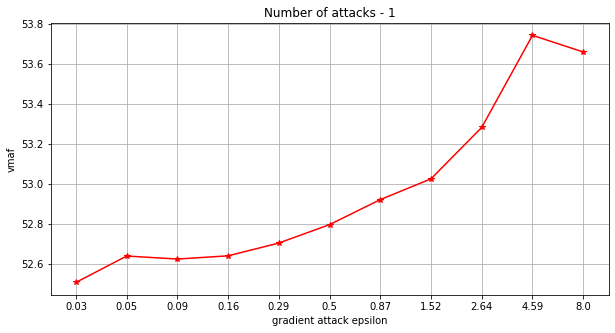

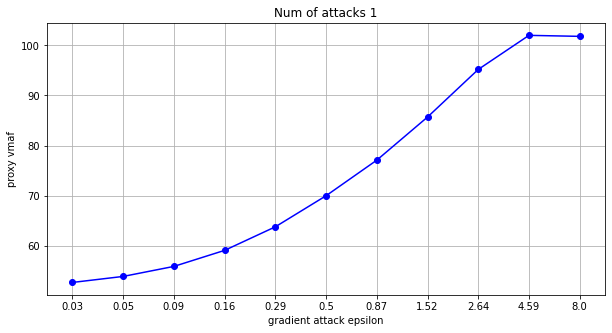

--------------------------------------------------------------------------------


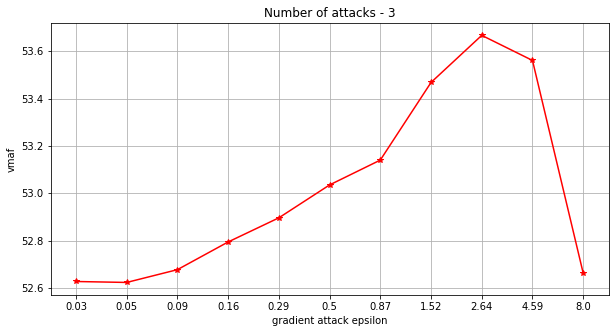

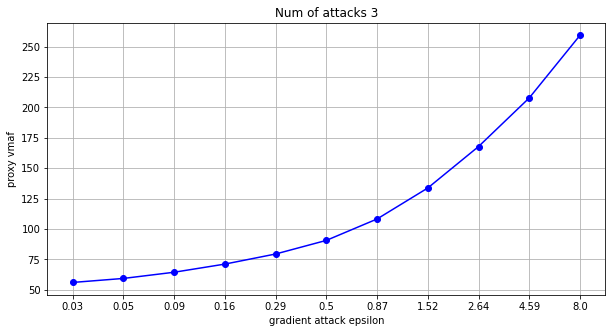

--------------------------------------------------------------------------------


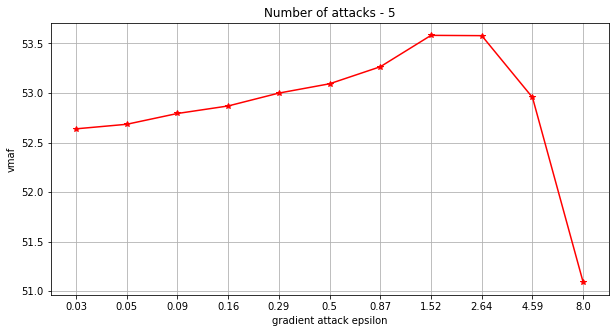

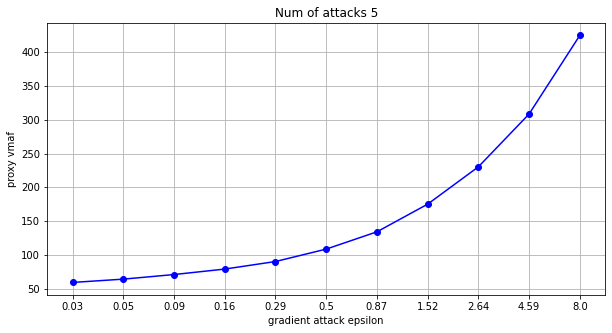

--------------------------------------------------------------------------------


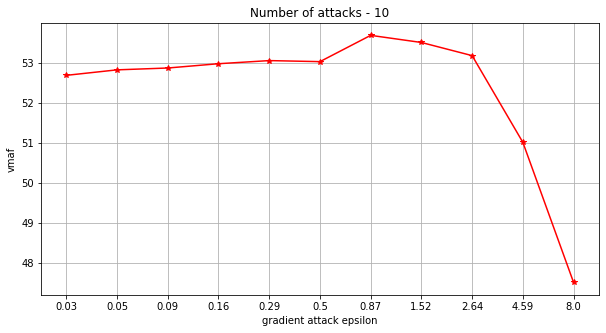

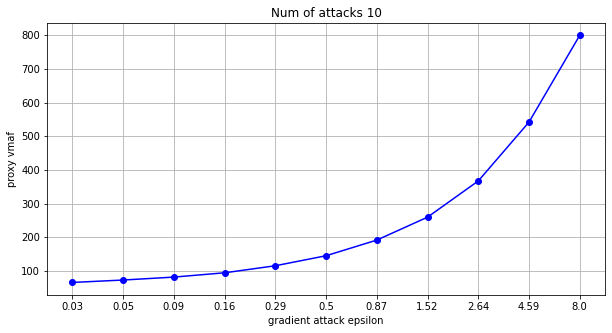

--------------------------------------------------------------------------------


In [436]:
for metricss_, iter_ in zip(metricsss, [1,3,5,10]):
    arr = np.array(metricss_).T
    plt.figure(figsize=(10,5))
    plt.grid()
    plt.title(f'Number of attacks - {iter_}')
    plt.plot(logs, arr[0], 'r*-')
    plt.ylabel('vmaf')
    plt.xlabel('gradient attack epsilon')
    plt.show()
    
    plt.figure(figsize=(10,5))
    plt.grid()
    plt.title(f'Num of attacks {iter_}')
    plt.plot(logs, arr[1] * 100,'bo-')
    plt.ylabel('proxy vmaf')
    plt.xlabel('gradient attack epsilon')
    plt.show()
    
    print('-' * 80)

In [366]:
temp_img = image.detach().clone()

model.eval()
for i in range(1000):
    pert_img = do_adversarial_iteration(model, temp_img, ref_image, eps=one_pix_delta)
    
    real_vmaf = get_vmaf_inshape(ref_image, pert_img)
    proxy_vmaf = model(pert_img[None].cuda(), ref_image[None].cuda())[0].item()
    
    psnr_met = psnr(pert_img, ref_image).item()
    ssim_met = ssim(pert_img, ref_image).item()
    
    temp_img = pert_img.detach().clone()
    
    metrics = np.array([real_vmaf, proxy_vmaf, psnr_met, ssim_met]).round(3)

    print(i, "\t".join(map(str,metrics)))
#     np_pertur_img = dcn(perturbed_image)[0][0]
#     plt.imshow(np_pertur_img, cmap='gray')
#     plt.show()

0 52.768	0.752	33.926	0.925
1 52.873	0.901	33.923	0.924
2 52.973	1.043	33.917	0.924
3 53.014	1.176	33.904	0.923
4 53.25	1.303	33.888	0.923
5 53.217	1.428	33.866	0.922
6 53.499	1.546	33.84	0.921
7 53.359	1.666	33.812	0.92
8 53.422	1.783	33.778	0.919
9 53.231	1.887	33.743	0.918
10 53.451	1.988	33.702	0.916
11 53.428	2.088	33.661	0.915
12 53.244	2.185	33.614	0.913
13 53.422	2.278	33.566	0.912
14 53.406	2.372	33.515	0.91
15 53.257	2.465	33.461	0.909
16 53.158	2.556	33.406	0.907
17 53.152	2.65	33.347	0.905
18 53.007	2.738	33.287	0.903
19 53.018	2.826	33.223	0.901
20 52.884	2.911	33.159	0.9
21 52.895	2.998	33.093	0.898
22 52.794	3.079	33.025	0.896
23 52.734	3.163	32.955	0.893
24 52.659	3.247	32.884	0.891
25 52.591	3.329	32.811	0.889
26 52.565	3.41	32.736	0.887
27 52.372	3.493	32.66	0.885
28 52.383	3.574	32.584	0.883
29 52.405	3.657	32.505	0.88


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-366-39a1c627773b>", line 7, in <module>
    real_vmaf = get_vmaf_inshape(ref_image, pert_img)
  File "<ipython-input-328-2ea6060b769f>", line 4, in get_vmaf_inshape
    return calc_vmaf(discretize_img(dcn(org_img_rs)[0]), discretize_img(dcn(comp_img_rs)[0]))
  File "<ipython-input-313-a79693670c86>", line 26, in calc_vmaf
    subproc.wait()
  File "/usr/lib/python3.8/subprocess.py", line 1079, in wait
    return self._wait(timeout=timeout)
  File "/usr/lib/python3.8/subprocess.py", line 1804, in _wait
    (pid, sts) = self._try_wait(0)
  File "/usr/lib/python3.8/subprocess.py", line 1762, in _try_wait
    (pid, sts) = os.waitpid(self.pid, wait_flags)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/

KeyboardInterrupt: 

In [760]:
# imgs = {}
# for eps in np.logspace(0,-20,21, base=2):
#     with torch.no_grad():
#         perturbed_image = fgsm_attack(image, eps, img_grad)

#         real_vmaf = get_vmaf_inshape(ref_image[0], perturbed_image[0])

#         print(eps, model(perturbed_image.cuda(), ref_image.cuda())[0].item(), real_vmaf)
#         np_pertur_img = dcn(perturbed_image)[0][0]
#         plt.imshow(np_pertur_img, cmap='gray')
#         plt.show()
#         imgs[eps] = np_pertur_img
#         plt.imshow(np_pertur_img, cmap='gray')
#         plt.show()

In [358]:
grad_img = conv_block(image)

In [ ]:
for i in range(10):
    model.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
data.requires_grad = True

In [ ]:
for lr in np.logspace(-3,-6,4):
    for epoch in range(EPOCHS):
        plot.start_time()
        cum_loss = 0
        for images, ref_images, scores in tqdm(trainloader):
            images = images.to(device)
            ref_images = ref_images.to(device)
            scores = scores / 100 # re-normalise
            scores = scores.to(device)
            out = conv_block(images)
            optimizer.zero_grad()
            loss = loss_function(out.float().squeeze(), scores.float())
            cum_loss += loss.item()
            loss.backward()
            optimizer.step()
        tr_loss = cum_loss / len(trainloader)
        val_loss = calc_loss(model, testloader, loss_function) / len(testloader)
        
        torch.save(model.state_dict(), logdir +
                   f"/proxy_{tr_loss:.4f}_{val_loss:.4f}")

        plot.append_train_loss(tr_loss)
        plot.append_test_loss(val_loss)
        plot.print_last()
        plot.print_time()

In [317]:
# fp.write(data_or.tobytes())

In [320]:
# subproc = Popen(
#     f"vqmt -stdin-orig raw IYUV {q} -stdin raw IYUV {q} -metr vmaf -set 'model_preset=vmaf_v063' -json",
#     stdout=PIPE, stderr=PIPE, stdin=fp, shell=True
# )
# subproc.wait()
# std_out, std_err = subproc.communicate()
# print(std_out.decode("utf-8"))
# print(std_err.decode("utf-8"))
# proc_out = std_out.decode("utf-8")
# float(proc_out.split('\n')[0])

In [758]:
# for idx in bad_diff_ids:
#     enc_name = train_dataset.item_names[idx]
#     enc_path = train_dataset.enc_name2path[enc_name]
#     org_path = train_dataset.enc_to_org_paths[enc_path]
#     score = train_dataset.jsons[enc_name]

#     np_a=np.array(Image.open(enc_path))

#     np_b=np.array(Image.open(org_path))

#     plt.figure(figsize=(5,5))
#     plt.imshow(np.vstack([np_b, np_a]),cmap='gray')
#     plt.title(np.round(score))
#     plt.show()

# info = []

# for i in range(1000):
#     enc_name = train_dataset.item_names[i]
#     enc_path = train_dataset.enc_name2path[enc_name]
#     org_path = train_dataset.enc_to_org_paths[enc_path]
#     score = train_dataset.jsons[enc_name]

#     qua = "1080x1920"

#     subproc = Popen(
#         f"vqmt -orig {org_path} IYUV {qua} -in {enc_path} IYUV {qua} -metr vmaf -set 'model_preset=vmaf_v063' -json -threads 3 | jq '.accumulated.mean.A'",
#         stdout=PIPE, stderr=PIPE, shell=True
#     )
#     subproc.wait()
#     std_out, std_err = subproc.communicate()
#     proc_out = std_out.decode("utf-8")
#     util_score = float(proc_out.split('\n')[0])
    
#     if np.abs(util_score-score) > 50:
#         print(enc_path)

# for im_train, ref_train, scores_train in trainloader:
#     for img, org_img, score in zip(im_train, ref_train, scores_train):
#         print(get_vmaf_inshape(org_img, img), score.item())

In [759]:
def calc_autoenc_loss(model, loader, loss_function):
    ep_loss = 0
    for images, ref_images, scores in loader:
        images = images.to(device)
        
        out = model(images)

        gt_image = images.detach()

        optimizer.zero_grad()
        loss = loss_function(out.float().view(-1), gt_image.view(-1))
        ep_loss += loss.item()
    return ep_loss

def train_autoencoder(model, loss_function, optimizer, epochs, device, plot):
    for epoch in range(epochs):
        plot.start_time()

        plot.append_train_loss(calc_autoenc_loss(model, trainloader, loss_function)/len(trainset))
        plot.append_test_loss(calc_autoenc_loss(model, testloader, loss_function)/len(testset))

        for images, ref_images, scores in trainloader:
            images = images.to(device).float()
            gt_image = images.detach()
            
            out = model(images)
            
            loss = loss_function(out, gt_image)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        plot.print_last()
        plot.print_time()

In [224]:
loss_function = nn.MSELoss().to(device)
plot = Plotter()

In [ ]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-7, weight_decay=1e-3)
train_autoencoder(autoencoder, loss_function, optimizer, 1, device, plot)
for lr in np.logspace(-2,-6,4):
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr, weight_decay=1e-3)
    train_autoencoder(autoencoder, loss_function, optimizer, 5, device, plot)

In [ ]:
plot.show()